In [2]:
import datetime

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

### 1.Préparation de la DataSet

In [3]:
#importation de quatre indices de marché : indice boursier total américain (VTI), indice obligataire agrégé américain (AGG), indice américain des matières premières (DBC) et indice de volatilité (VIX)
AGG_DB = pd.read_csv("DataBase/AGG.csv", delimiter=",",parse_dates=["Date"])
DBC_DB = pd.read_csv("DataBase/DBC.csv", delimiter=",")
VIX_DB = pd.read_csv("DataBase/VIX.csv", delimiter=",")
VTI_DB = pd.read_csv("DataBase/VTI.csv", delimiter=",")


In [4]:
AGG_DB.head()




,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-02-07,100.330002,100.339996,99.930000,100.139999,58.008472,122900
1,2006-02-08,100.190002,100.239998,100.029999,100.089996,57.979443,146800
2,2006-02-09,100.129997,100.250000,99.910004,100.150002,58.014259,144200
3,2006-02-10,100.139999,100.230003,99.820000,99.940002,57.892593,118100
4,2006-02-13,99.989998,100.010002,99.820000,100.010002,57.933155,109600


In [5]:
DBC_DB.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-02-07,24.049999,24.200001,23.450001,23.500000,20.285254,674400
1,2006-02-08,23.490000,23.670000,23.330000,23.400000,20.198936,335400
2,2006-02-09,23.559999,23.820000,23.510000,23.620001,20.388842,705900
3,2006-02-10,23.650000,23.690001,23.100000,23.190001,20.017660,276700
4,2006-02-13,23.190001,23.200001,22.770000,22.830000,19.706907,237600


In [6]:
VIX_DB.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-02-07,13.20,13.67,12.97,13.59,13.59,0.0
1,2006-02-08,13.41,13.61,12.76,12.83,12.83,0.0
2,2006-02-09,12.56,13.15,12.27,13.12,13.12,0.0
3,2006-02-10,13.35,13.73,12.69,12.87,12.87,0.0
4,2006-02-13,13.34,13.70,13.05,13.35,13.35,0.0


In [7]:
VTI_DB['Date'] = pd.to_datetime(VTI_DB['Date'], format='%m/%d/%Y')
VTI_DB['Date'] = VTI_DB['Date'].dt.strftime('%m-%d-%Y')

VTI_DB.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02-07-2006,63.000000,63.160000,62.500000,62.549999,44.669655,570000
1,02-08-2006,62.619999,63.090000,62.505001,63.000000,44.991016,396400
2,02-09-2006,63.174999,63.455002,62.820000,62.880001,44.905331,213000
3,02-10-2006,62.830002,63.130001,62.404999,63.009998,44.998150,359000
4,02-13-2006,62.970001,62.970001,62.544998,62.724998,44.794632,334200


In [8]:
# Calcul du rendement quotidien (daily return)
def calculate_daily_return(data):
    data['DailyReturn'] = data['Close'].pct_change() 


calculate_daily_return(VTI_DB)
calculate_daily_return(AGG_DB)
calculate_daily_return(DBC_DB)
calculate_daily_return(VIX_DB)

In [9]:
print("VTI_DB with daily return\n", VTI_DB.head())


VTI_DB with daily return
          Date       Open       High        Low      Close  Adj Close  Volume  \
0  02-07-2006  63.000000  63.160000  62.500000  62.549999  44.669655  570000   
1  02-08-2006  62.619999  63.090000  62.505001  63.000000  44.991016  396400   
2  02-09-2006  63.174999  63.455002  62.820000  62.880001  44.905331  213000   
3  02-10-2006  62.830002  63.130001  62.404999  63.009998  44.998150  359000   
4  02-13-2006  62.970001  62.970001  62.544998  62.724998  44.794632  334200   

   DailyReturn  
0          NaN  
1     0.007194  
2    -0.001905  
3     0.002067  
4    -0.004523  


In [10]:

# convertir la colonne 'Date' en un format de données datetime
VTI_DB['Date'] = pd.to_datetime(VTI_DB['Date'])
AGG_DB['Date'] = pd.to_datetime(AGG_DB['Date'])
DBC_DB['Date'] = pd.to_datetime(DBC_DB['Date'])
VIX_DB['Date'] = pd.to_datetime(VIX_DB['Date'])

# fusionner les index


merged_df = pd.merge(VTI_DB, AGG_DB, on='Date', how='inner', suffixes=('_VTI', '_AGG'))
merged_df = pd.merge(merged_df, DBC_DB, on='Date', how='inner', suffixes=('_DBC', '_Merged'))  
merged_df = pd.merge(merged_df, VIX_DB, on='Date', how='inner', suffixes=('_VIX', '_Merged'))  


merged_df.head

<bound method NDFrame.head of            Date    Open_VTI    High_VTI     Low_VTI   Close_VTI  \
0    2006-02-07   63.000000   63.160000   62.500000   62.549999   
1    2006-02-08   62.619999   63.090000   62.505001   63.000000   
2    2006-02-09   63.174999   63.455002   62.820000   62.880001   
3    2006-02-10   62.830002   63.130001   62.404999   63.009998   
4    2006-02-13   62.970001   62.970001   62.544998   62.724998   
...         ...         ...         ...         ...         ...   
3746 2020-12-23  193.649994  194.220001  193.160004  193.279999   
3747 2020-12-24  192.880005  193.000000  192.240005  192.820007   
3748 2020-12-28  194.589996  194.600006  193.800003  194.039993   
3749 2020-12-29  194.860001  194.949997  192.820007  193.229996   
3750 2020-12-30  193.899994  194.380005  193.610001  193.750000   

      Adj Close_VTI  Volume_VTI  DailyReturn_VTI    Open_AGG    High_AGG  ...  \
0         44.669655      570000              NaN  100.330002  100.339996  ...   
1  

In [11]:
# Cration d'un nouveau DataFrame pour le portefeuille final
selected_columns = [
    'Date',
    'Close_VTI', 'DailyReturn_VTI',
    'Close_AGG', 'DailyReturn_AGG',
    'Close_Merged', 'DailyReturn_Merged',  
    'Close_VIX', 'DailyReturn_VIX',  
]

portfolio_df = merged_df[selected_columns]

portfolio_df.columns = ['Date',
                         'VTI_Close', 'VTI_Daily_Return',
                         'AGG_Close', 'AGG_Daily_Return',
                         'DBC_Close', 'DBC_Daily_Return',
                         'VIX_Close', 'VIX_Daily_Return']


portfolio_df.head

<bound method NDFrame.head of            Date   VTI_Close  VTI_Daily_Return   AGG_Close  AGG_Daily_Return  \
0    2006-02-07   62.549999               NaN  100.139999               NaN   
1    2006-02-08   63.000000          0.007194  100.089996         -0.000499   
2    2006-02-09   62.880001         -0.001905  100.150002          0.000600   
3    2006-02-10   63.009998          0.002067   99.940002         -0.002097   
4    2006-02-13   62.724998         -0.004523  100.010002          0.000700   
...         ...         ...               ...         ...               ...   
3746 2020-12-23  193.279999          0.001710  117.879997         -0.000678   
3747 2020-12-24  192.820007         -0.002380  117.989998          0.000933   
3748 2020-12-28  194.039993          0.006327  118.010002          0.000170   
3749 2020-12-29  193.229996         -0.004174  118.029999          0.000169   
3750 2020-12-30  193.750000          0.002691  118.099998          0.000593   

      DBC_Close  DBC_

In [12]:
#Data cleaning
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])
portfolio_df = portfolio_df.dropna()
portfolio_df.head

C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\3973616344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])


<bound method NDFrame.head of            Date   VTI_Close  VTI_Daily_Return   AGG_Close  AGG_Daily_Return  \
1    2006-02-08   63.000000          0.007194  100.089996         -0.000499   
2    2006-02-09   62.880001         -0.001905  100.150002          0.000600   
3    2006-02-10   63.009998          0.002067   99.940002         -0.002097   
4    2006-02-13   62.724998         -0.004523  100.010002          0.000700   
5    2006-02-14   63.320000          0.009486   99.849998         -0.001600   
...         ...         ...               ...         ...               ...   
3746 2020-12-23  193.279999          0.001710  117.879997         -0.000678   
3747 2020-12-24  192.820007         -0.002380  117.989998          0.000933   
3748 2020-12-28  194.039993          0.006327  118.010002          0.000170   
3749 2020-12-29  193.229996         -0.004174  118.029999          0.000169   
3750 2020-12-30  193.750000          0.002691  118.099998          0.000593   

      DBC_Close  DBC_

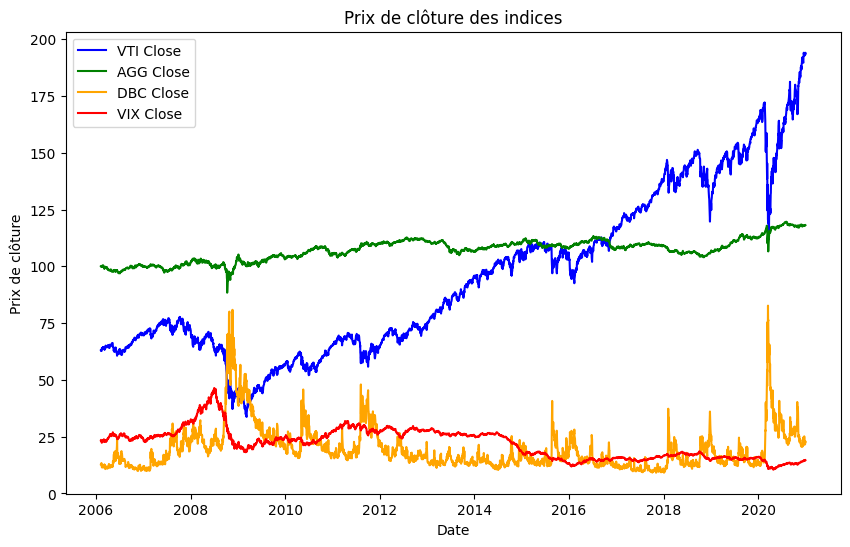

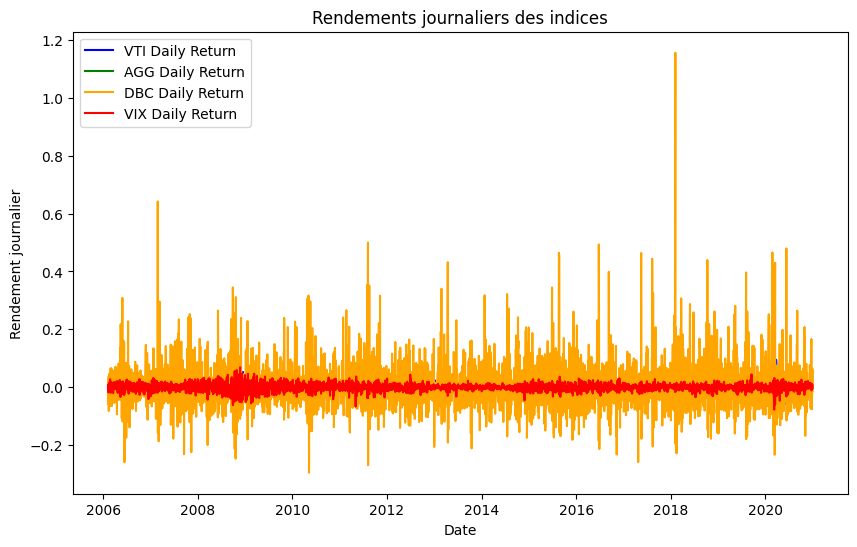

In [13]:

# Tracer les prix de clôture
plt.figure(figsize=(10, 6))
plt.plot(portfolio_df['Date'], portfolio_df['VTI_Close'], label='VTI Close', color='blue')
plt.plot(portfolio_df['Date'], portfolio_df['AGG_Close'], label='AGG Close', color='green')
plt.plot(portfolio_df['Date'], portfolio_df['DBC_Close'], label='DBC Close', color='orange')
plt.plot(portfolio_df['Date'], portfolio_df['VIX_Close'], label='VIX Close', color='red')

plt.title('Prix de clôture des indices')
plt.xlabel('Date')
plt.ylabel('Prix de clôture')
plt.legend()
plt.show()

# Tracer les rendements journaliers
plt.figure(figsize=(10, 6))
plt.plot(portfolio_df['Date'], portfolio_df['VTI_Daily_Return'], label='VTI Daily Return', color='blue')
plt.plot(portfolio_df['Date'], portfolio_df['AGG_Daily_Return'], label='AGG Daily Return', color='green')
plt.plot(portfolio_df['Date'], portfolio_df['DBC_Daily_Return'], label='DBC Daily Return', color='orange')
plt.plot(portfolio_df['Date'], portfolio_df['VIX_Daily_Return'], label='VIX Daily Return', color='red')

plt.title('Rendements journaliers des indices')
plt.xlabel('Date')
plt.ylabel('Rendement journalier')
plt.legend()
plt.show()




   
  


# <font color='green'>
#####  Analyse des données

In [14]:
#Vérifier la stationnarité des données à l'aide de tests statistiques
#Augmented Dickey-Fuller test
def ADF(df):
    result = sm.tsa.stattools.adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

# Liste des colonnes à tester
columns_to_test_close = ['VTI_Close', 'AGG_Close', 'DBC_Close',  'VIX_Close']
columns_to_test_Dailyreturn = [ 'VTI_Daily_Return','AGG_Daily_Return',  'DBC_Daily_Return', 'VIX_Daily_Return']

# Appliquer la fonction ADF à chaque colonne

print(f"Test de stationnarité Prix de cloture:")
for column in columns_to_test_close:
    print(f"Test de stationnarité pour la colonne {column}:")
    ADF(portfolio_df[column])
    print("\n" + "="*50 + "\n")

print(f"Test de stationnarité rendement journalier:")
for column in columns_to_test_Dailyreturn:
    print(f"Test de stationnarité pour la colonne {column}:")
    ADF(portfolio_df[column])
    print("\n" + "="*50 + "\n")

Test de stationnarité Prix de cloture:
Test de stationnarité pour la colonne VTI_Close:
ADF Statistic: 1.1020358554679033
p-value: 0.9952339603594496
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test de stationnarité pour la colonne AGG_Close:
ADF Statistic: -1.0977623059489725
p-value: 0.7159634462046274
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test de stationnarité pour la colonne DBC_Close:
ADF Statistic: -4.712433027029312
p-value: 7.974175836909714e-05
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test de stationnarité pour la colonne VIX_Close:
ADF Statistic: -1.5793911957836402
p-value: 0.4939371700849118
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test de stationnarité rendement journalier:
Test de stationnarité pour la colonne VTI_Daily_Return:
ADF Statistic: -15.132934492368896
p-value: 7.188722781703905e-28
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


Test de stationnarité pour la colonne AGG_Daily_Return:
ADF Statis


Conclusion :
- Les prix de clôture de 'VTI', 'AGG', 'DBC', et 'VIX' ne sont pas stationnaires.
- Les rendements journaliers de 'VTI', 'AGG', 'DBC', et 'VIX' sont stationnaires.

--> les rendements journaliers sont plus susceptibles d'être utilisés pour les analyses financières

In [15]:
# Appliquer la différenciation pour rendre les prix de clôture stationnaires
# Colonnes à traiter
close_columns = ['VTI_Close', 'AGG_Close', 'DBC_Close', 'VIX_Close']

# Appliquer la différenciation à chaque colonne
for column in close_columns:
    portfolio_df[f'{column}_Stationary'] = portfolio_df[column].diff().dropna()

# Afficher les 5 premières lignes du résultat
print(portfolio_df[['Date'] + [f'{column}_Stationary' for column in close_columns]].head())


        Date  VTI_Close_Stationary  AGG_Close_Stationary  \
1 2006-02-08                   NaN                   NaN   
2 2006-02-09             -0.119999              0.060006   
3 2006-02-10              0.129997             -0.210000   
4 2006-02-13             -0.285000              0.070000   
5 2006-02-14              0.595002             -0.160004   

   DBC_Close_Stationary  VIX_Close_Stationary  
1                   NaN                   NaN  
2                  0.29              0.220001  
3                 -0.25             -0.430000  
4                  0.48             -0.360001  
5                 -1.10             -0.190001  


C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\2818940235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df[f'{column}_Stationary'] = portfolio_df[column].diff().dropna()
C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\2818940235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df[f'{column}_Stationary'] = portfolio_df[column].diff().dropna()
C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\2818940235.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [16]:
portfolio_df.head()

,Date,VTI_Close,VTI_Daily_Return,AGG_Close,AGG_Daily_Return,DBC_Close,DBC_Daily_Return,VIX_Close,VIX_Daily_Return,VTI_Close_Stationary,AGG_Close_Stationary,DBC_Close_Stationary,VIX_Close_Stationary
1,2006-02-08,63.000000,0.007194,100.089996,-0.000499,12.83,-0.055923,23.400000,-0.004255,NaN,NaN,NaN,NaN
2,2006-02-09,62.880001,-0.001905,100.150002,0.000600,13.12,0.022603,23.620001,0.009402,-0.119999,0.060006,0.29,0.220001
3,2006-02-10,63.009998,0.002067,99.940002,-0.002097,12.87,-0.019055,23.190001,-0.018205,0.129997,-0.210000,-0.25,-0.430000
4,2006-02-13,62.724998,-0.004523,100.010002,0.000700,13.35,0.037296,22.830000,-0.015524,-0.285000,0.070000,0.48,-0.360001
5,2006-02-14,63.320000,0.009486,99.849998,-0.001600,12.25,-0.082397,22.639999,-0.008322,0.595002,-0.160004,-1.10,-0.190001


c:\Users\chaft\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


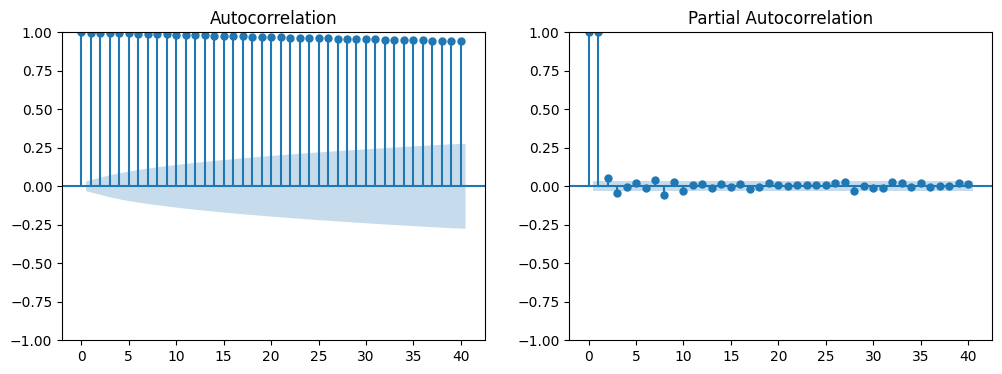

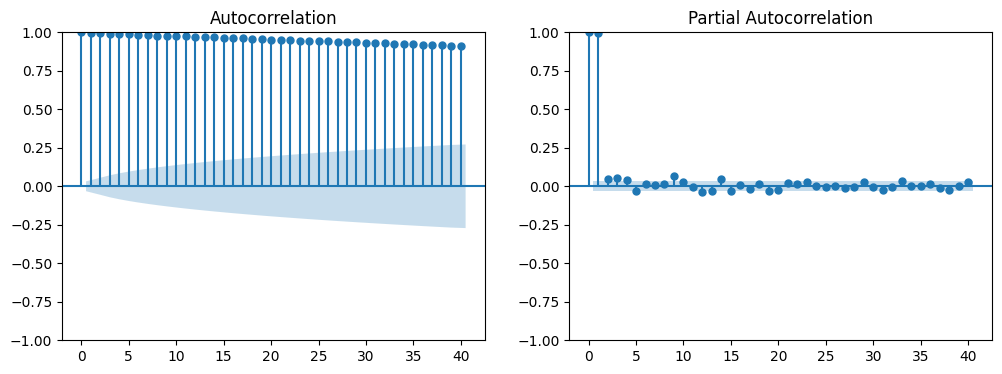

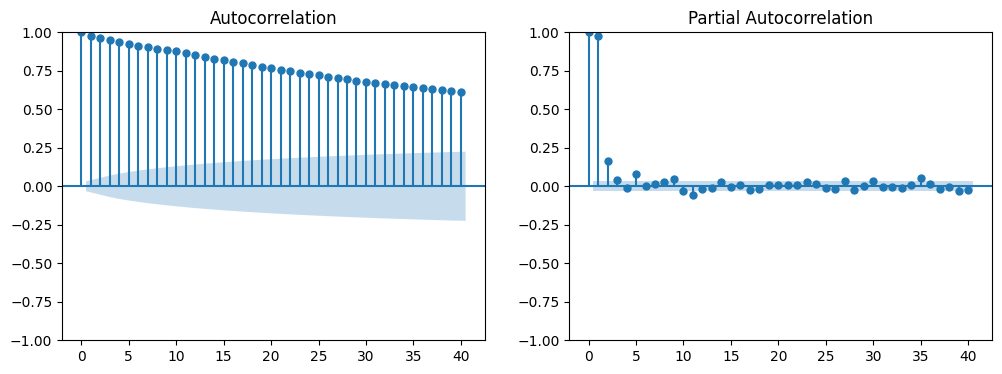

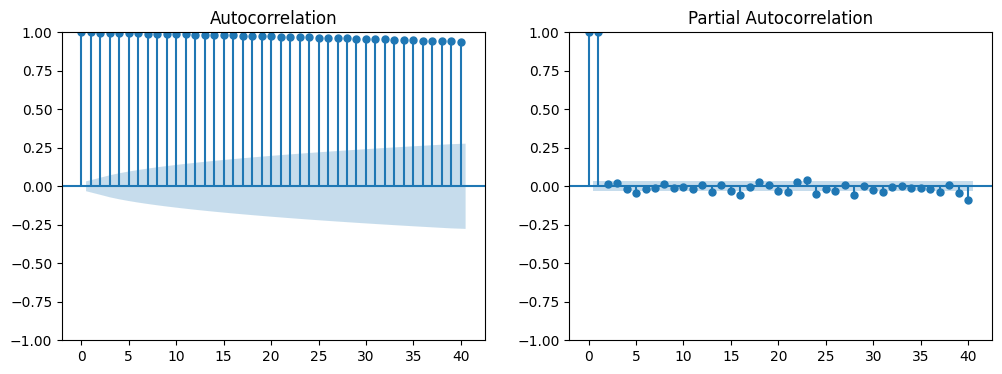

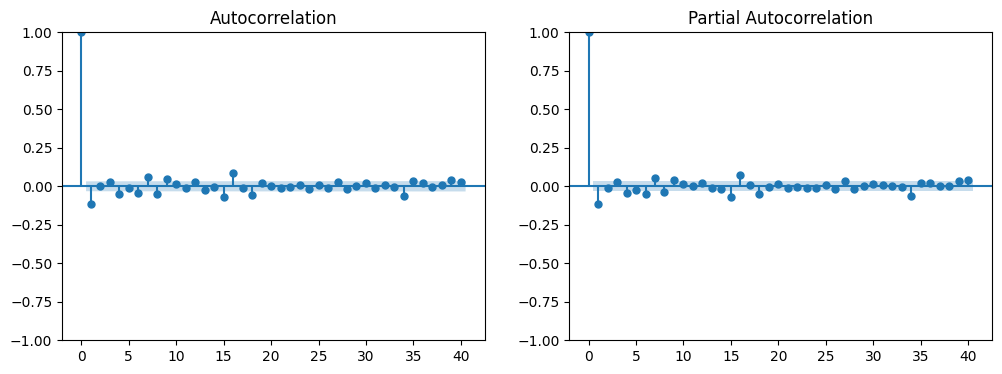

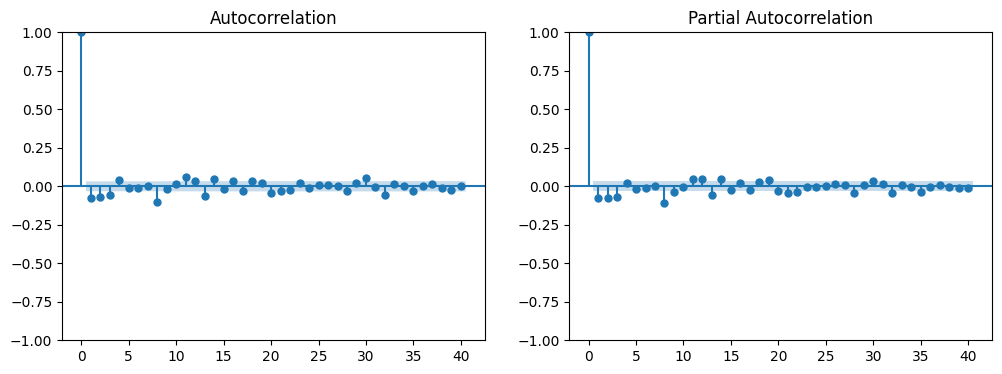

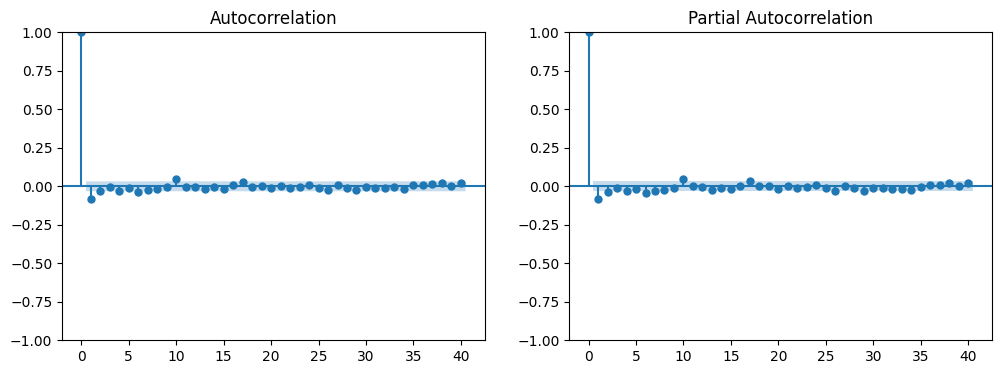

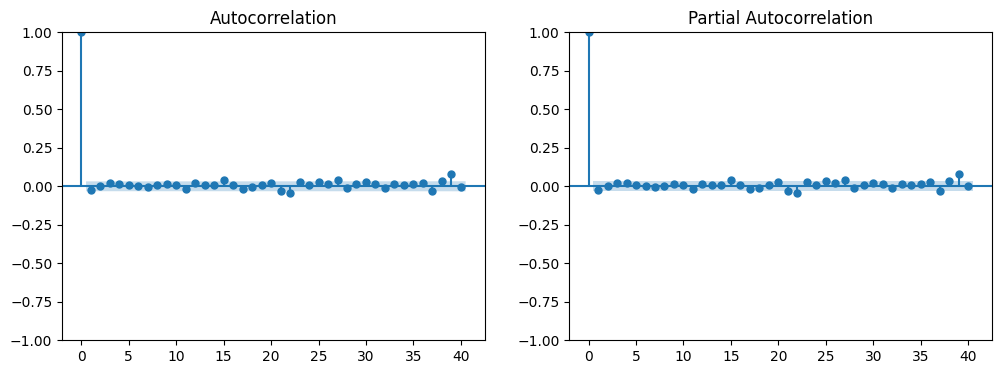

In [17]:
# Fonction pour vérifier l'autocorrélation
def check_autocorrelation(series, lags=40):
    # Tracer l'ACF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sm.graphics.tsa.plot_acf(series, lags=lags, ax=ax[0])
    
    # Tracer le PACF
    sm.graphics.tsa.plot_pacf(series, lags=lags, ax=ax[1])
    
    plt.show()

# Vérifier l'autocorrélation pour les colonnes de prix de clôture
for column in close_columns:
    check_autocorrelation(portfolio_df[f'{column}'].dropna(), lags=40)

# Vérifier l'autocorrélation pour les colonnes de rendement journalier
return_columns = ['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']
for column in return_columns:
    check_autocorrelation(portfolio_df[column].dropna(), lags=40)

conclusion

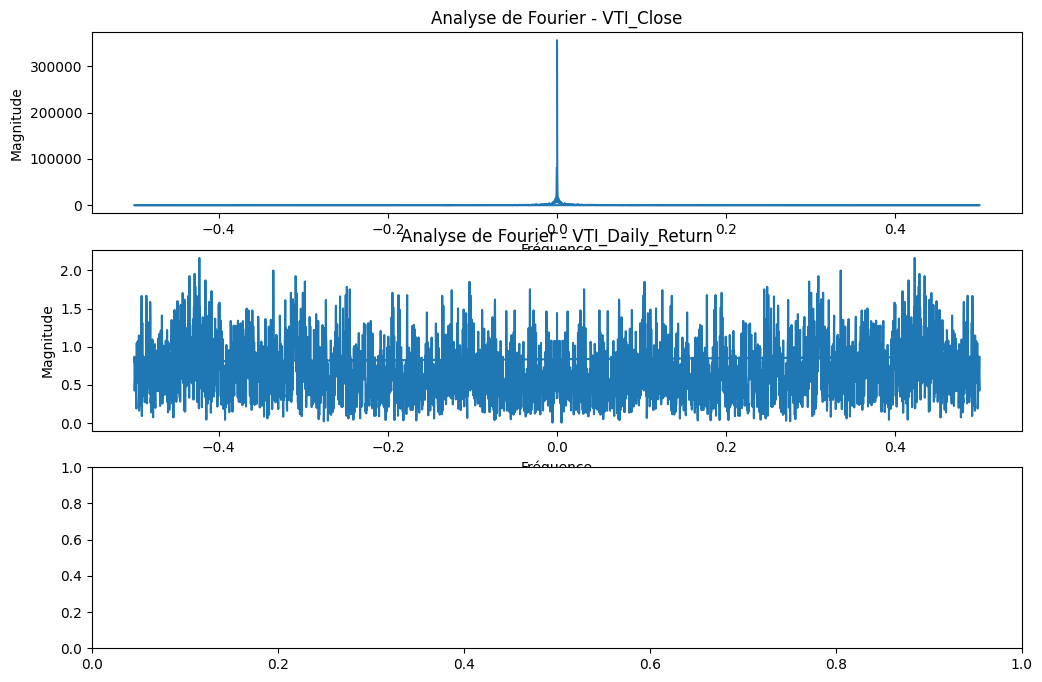

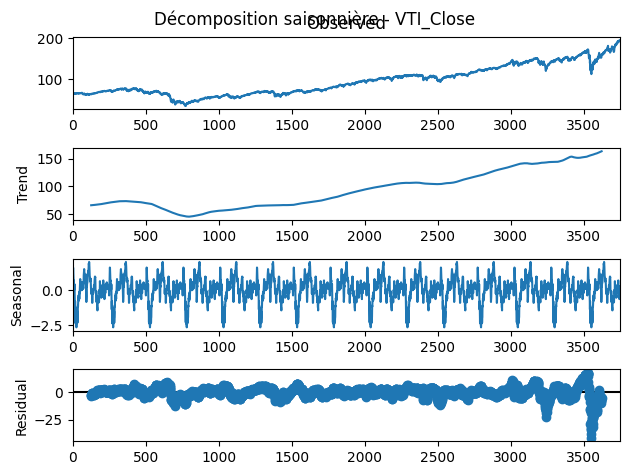

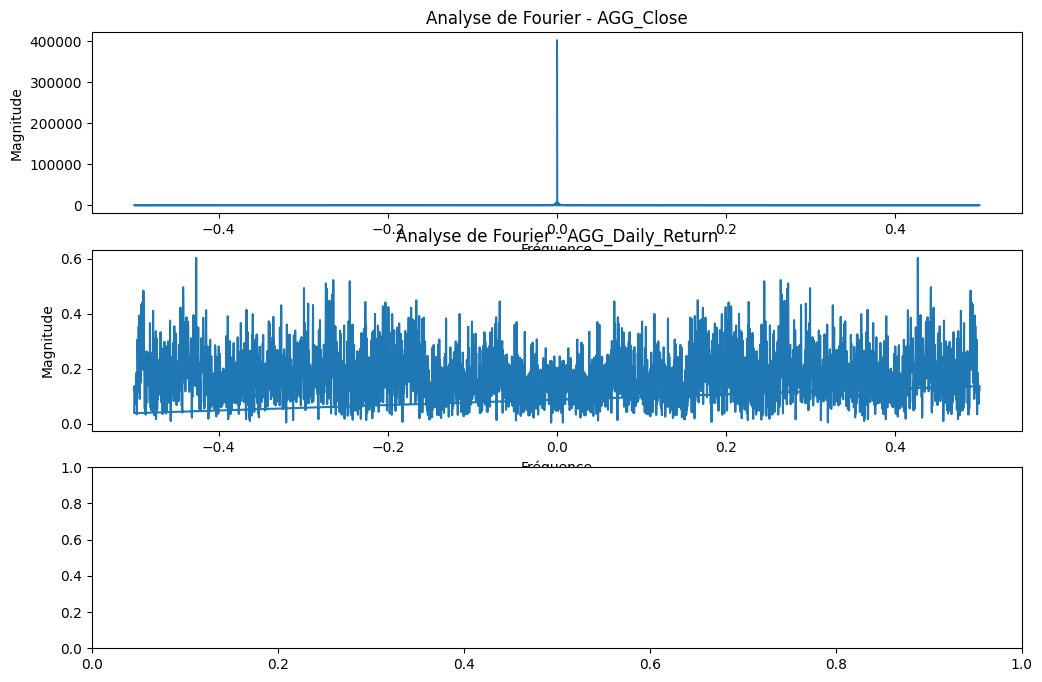

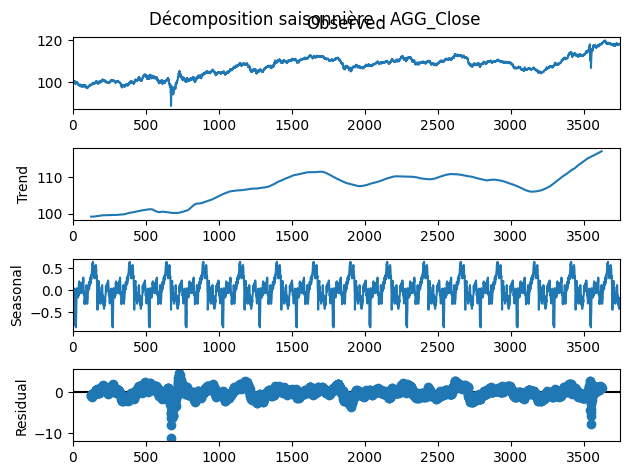

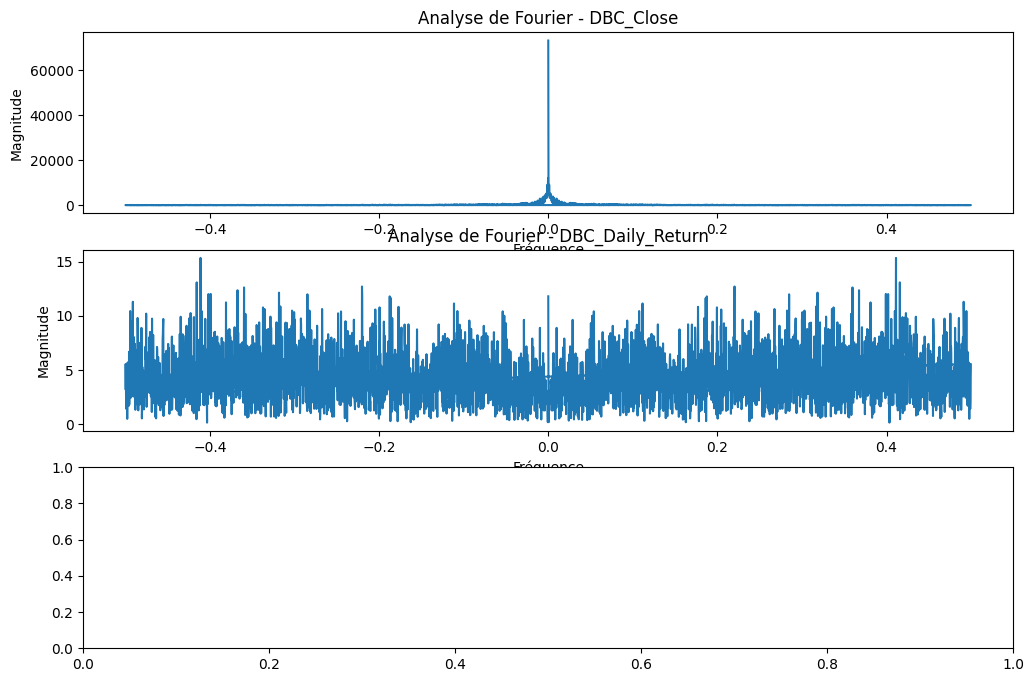

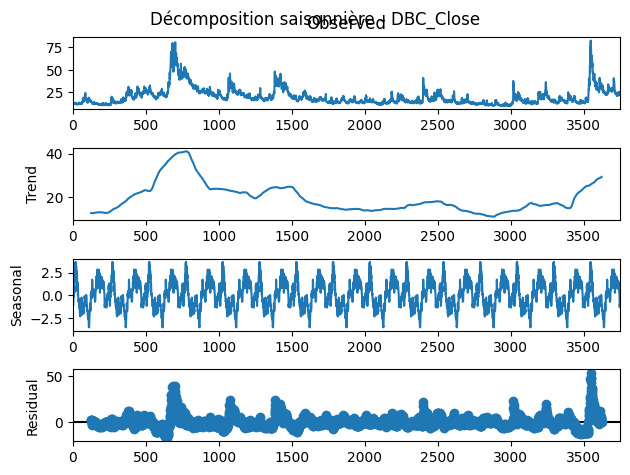

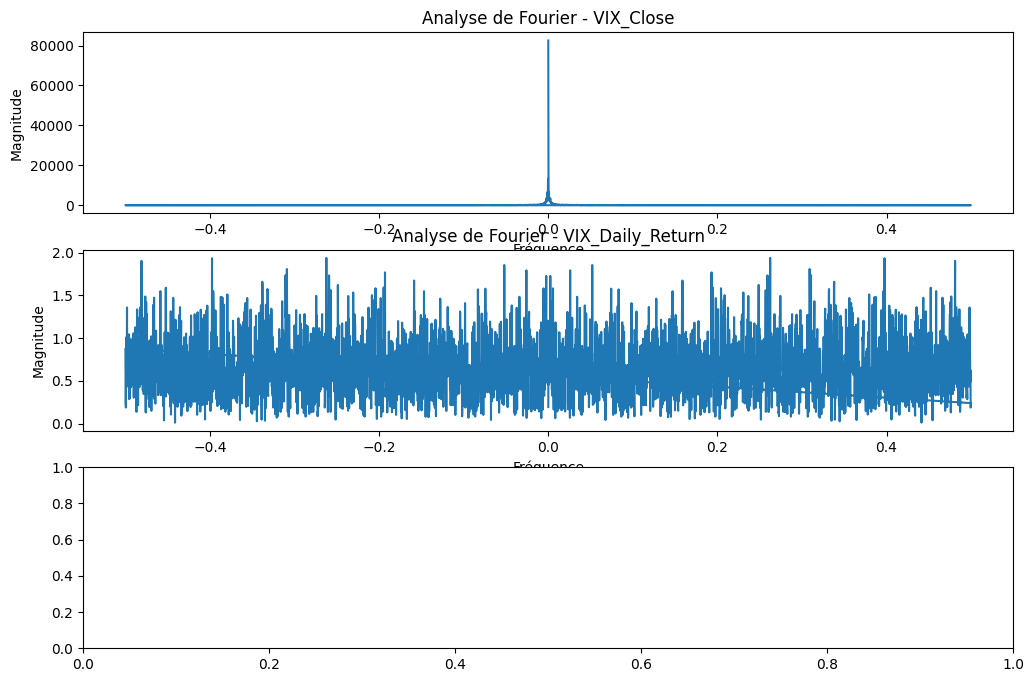

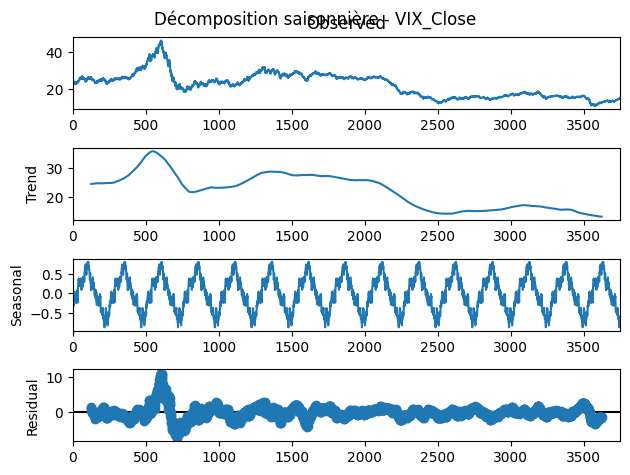

In [18]:
close_columns = ['VTI_Close', 'AGG_Close', 'DBC_Close', 'VIX_Close']
daily_return_columns = ['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']

# Analyse de Fourier et décomposition saisonnière pour chaque colonne
for close_col, daily_return_col in zip(close_columns, daily_return_columns):
    # Analyse de Fourier pour identifier les fréquences saisonnières significatives pour les prix de clôture
    returns_close = portfolio_df[close_col].dropna().values
    fourier_transform_close = np.fft.fft(returns_close)
    frequencies_close = np.fft.fftfreq(len(fourier_transform_close))
    magnitude_close = np.abs(fourier_transform_close)

    # Indices des composantes significatives pour les prix de clôture
    significant_indices_close = np.where(magnitude_close > 0.1 * magnitude_close.max())
    significant_frequencies_close = frequencies_close[significant_indices_close]

    # Affichage des résultats pour les prix de clôture
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(frequencies_close, magnitude_close)
    plt.title(f'Analyse de Fourier - {close_col}')
    plt.xlabel('Fréquence')
    plt.ylabel('Magnitude')

    # Analyse de Fourier pour identifier les fréquences saisonnières significatives pour les rendements journaliers
    returns_daily = portfolio_df[daily_return_col].dropna().values
    fourier_transform_daily = np.fft.fft(returns_daily)
    frequencies_daily = np.fft.fftfreq(len(fourier_transform_daily))
    magnitude_daily = np.abs(fourier_transform_daily)

    # Indices des composantes significatives pour les rendements journaliers
    significant_indices_daily = np.where(magnitude_daily > 0.1 * magnitude_daily.max())
    significant_frequencies_daily = frequencies_daily[significant_indices_daily]

    # Affichage des résultats pour les rendements journaliers
    plt.subplot(3, 1, 2)
    plt.plot(frequencies_daily, magnitude_daily)
    plt.title(f'Analyse de Fourier - {daily_return_col}')
    plt.xlabel('Fréquence')
    plt.ylabel('Magnitude')

    # Décomposition saisonnière pour identifier les tendances saisonnières pour les prix de clôture
    decomposition_close = sm.tsa.seasonal_decompose(returns_close, model='additive', period=252)
    plt.subplot(3, 1, 3)
    decomposition_close.plot()
    plt.suptitle(f'Décomposition saisonnière - {close_col}')
    plt.show()

### 2.Methode d'optimisation analytique: frontiere efficiente

In [19]:
print(portfolio_df)

           Date   VTI_Close  VTI_Daily_Return   AGG_Close  AGG_Daily_Return  \
1    2006-02-08   63.000000          0.007194  100.089996         -0.000499   
2    2006-02-09   62.880001         -0.001905  100.150002          0.000600   
3    2006-02-10   63.009998          0.002067   99.940002         -0.002097   
4    2006-02-13   62.724998         -0.004523  100.010002          0.000700   
5    2006-02-14   63.320000          0.009486   99.849998         -0.001600   
...         ...         ...               ...         ...               ...   
3746 2020-12-23  193.279999          0.001710  117.879997         -0.000678   
3747 2020-12-24  192.820007         -0.002380  117.989998          0.000933   
3748 2020-12-28  194.039993          0.006327  118.010002          0.000170   
3749 2020-12-29  193.229996         -0.004174  118.029999          0.000169   
3750 2020-12-30  193.750000          0.002691  118.099998          0.000593   

      DBC_Close  DBC_Daily_Return  VIX_Close  VIX_D

In [20]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns



portfolio_df.dropna(inplace=True)
# Calculer les rendements attendus et la matrice de covariance du portefeuille
expected_returns_data = expected_returns.mean_historical_return(portfolio_df[['VTI_Close', 'AGG_Close', 'DBC_Close', 'VIX_Close']])
covariance_matrix_data = risk_models.sample_cov(portfolio_df[['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']])



ef = EfficientFrontier(expected_returns_data, covariance_matrix_data)

# Optimiser le portefeuille
ef.max_sharpe()



# Afficher les performances du portefeuille
ef.portfolio_performance(verbose=True)
# Obtenez les poids du portefeuille optimisé
print(ef.clean_weights())
efficient_weights = ef.clean_weights()

# Créez un DataFrame pour stocker les données du nouveau portefeuille
efficient_portfolio_data = portfolio_df[['Date']].copy()

# Ajoutez la colonne 'Efficient_Portfolio' au DataFrame avec le nouveau portefeuille
efficient_portfolio_data['Efficient_Portfolio'] = (portfolio_df[['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']] * list(efficient_weights.values())).sum(axis=1)

# Affichez les premières lignes du nouveau portefeuille
print(efficient_portfolio_data.head())



OrderedDict([('VTI_Close', 0.86773), ('AGG_Close', 0.0), ('DBC_Close', 0.13227), ('VIX_Close', 0.0)])
Expected annual return: 7.3%
Annual volatility: 17461.0%
Sharpe Ratio: 0.00
        Date  Efficient_Portfolio
2 2006-02-09             0.001337
3 2006-02-10            -0.000726
4 2006-02-13             0.001008
5 2006-02-14            -0.002667
6 2006-02-15             0.003937


C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\3049304134.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df.dropna(inplace=True)


### 3. Methode de ratio de sharp : Model LSTM

In [21]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [22]:
# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(portfolio_df[['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']])

In [23]:
# cration des input et output
X = []
y = []
for i in range(scaled_data.shape[0] - 50):
    X.append(scaled_data[i:i+50, :])
    y.append(scaled_data[i+50, :])
X = np.array(X)
y = np.array(y)

In [24]:
# Divisez les données en ensembles d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [25]:
# Creatiton du modele LSTM 
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(y_train.shape[1], activation='softmax'))

In [26]:
# Compiler le modele
optimizer = Adam(learning_rate=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])


In [27]:
# Apprentissage
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.1, verbose=2)

Epoch 1/100


47/47 - 6s - loss: 0.0517 - mae: 0.2141 - val_loss: 0.0488 - val_mae: 0.2130 - 6s/epoch - 119ms/step
Epoch 2/100
47/47 - 1s - loss: 0.0485 - mae: 0.2127 - val_loss: 0.0490 - val_mae: 0.2131 - 1s/epoch - 22ms/step
Epoch 3/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2129 - 1s/epoch - 23ms/step
Epoch 4/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2130 - 1s/epoch - 25ms/step
Epoch 5/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2130 - 1s/epoch - 25ms/step
Epoch 6/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2129 - 1s/epoch - 24ms/step
Epoch 7/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2129 - 1s/epoch - 24ms/step
Epoch 8/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0487 - val_mae: 0.2130 - 1s/epoch - 23ms/step
Epoch 9/100
47/47 - 1s - loss: 0.0484 - mae: 0.2127 - val_loss: 0.0488 - val_mae: 0.2129 - 1s/epoch -

In [28]:
# Evaluation du modele
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=2)
print(f'Test Mean Absolute Error: {test_mae}')

12/12 - 0s - loss: 0.0477 - mae: 0.2115 - 119ms/epoch - 10ms/step
Test Mean Absolute Error: 0.21145188808441162


In [29]:
# Utilisez le modèle pour prédire les pondérations du portefeuille
portfolio_weights = model.predict(X_test)


12/12 [==============================] - 1s 8ms/step


In [35]:
# Calculez les rendements réalisés en multipliant les poids du portefeuille avec les rendements réels
realized_returns = np.sum(portfolio_weights * y_test, axis=1)

# Calculez le ratio de Sharpe
sharpe_ratio = realized_returns.mean() / realized_returns.std()
print(f'Sharpe Ratio: {sharpe_ratio}')


print('Predicted Portfolio Weights:')
print(portfolio_weights)

Sharpe Ratio: 15.442449899714203
Predicted Portfolio Weights:
[[2.5853735e-01 4.3017915e-01 2.3291839e-04 3.1105056e-01]
 [2.5293031e-01 4.3469012e-01 2.3068718e-04 3.1214881e-01]
 [2.6626015e-01 4.2336178e-01 2.3240104e-04 3.1014571e-01]
 ...
 [2.5655976e-01 4.2937851e-01 2.3554635e-04 3.1382617e-01]
 [2.5839075e-01 4.3467778e-01 2.3137090e-04 3.0670011e-01]
 [2.5434893e-01 4.3255231e-01 2.3234186e-04 3.1286648e-01]]


### comparaison des résultats avec :
##### 1.Portefeuille initiale 
##### 2.Portefeuille de la methode frontiere efficiente

 __________________Portefeuille initiale

In [31]:
# Poids des indices dans le portefeuille initial (à ajuster selon vos préférences)
weights = {'VTI': 0.25, 'AGG': 0.25, 'DBC': 0.25, 'VIX': 0.25}

# Calculer le rendement quotidien du portefeuille initial
portfolio_df['DailyReturn_Portfolio'] = (
    weights['VTI'] * portfolio_df['VTI_Daily_Return'] +
    weights['AGG'] * portfolio_df['AGG_Daily_Return'] +
    weights['DBC'] * portfolio_df['DBC_Daily_Return'] +
    weights['VIX'] * portfolio_df['VIX_Daily_Return']
)

# Afficher les rendements quotidiens du portefeuille initial
print(portfolio_df['DailyReturn_Portfolio'])


2       0.007675
3      -0.009322
4       0.004487
5      -0.020708
6      -0.001197
          ...   
3746   -0.006105
3747   -0.018765
3748    0.002057
3749    0.015587
3750   -0.000990
Name: DailyReturn_Portfolio, Length: 3749, dtype: float64


C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\2433158190.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df['DailyReturn_Portfolio'] = (


______________Portefeuille de la methode frontiere efficiente

In [40]:

efficient_portfolio_data = portfolio_df[['Date']].copy()
efficient_portfolio_data['Efficient_Portfolio'] = (portfolio_df[['VTI_Daily_Return', 'AGG_Daily_Return', 'DBC_Daily_Return', 'VIX_Daily_Return']] * list(efficient_weights.values())).sum(axis=1)



________________ Comparaison

C:\Users\chaft\AppData\Local\Temp\ipykernel_188740\2455983002.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])


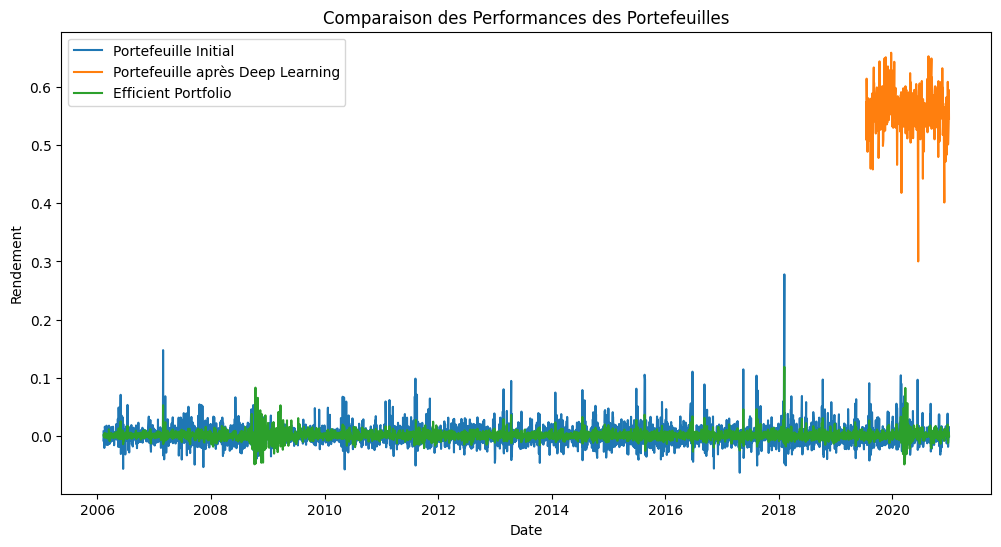

In [39]:
# Assuming 'Date' is in a datetime format in your DataFrames
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])
y_test_df = pd.DataFrame(y_test, index=portfolio_df['Date'][-len(y_test):])  # Assuming y_test corresponds to the last part of portfolio_df

# Affichez le graphique de comparaison des performances des portefeuilles
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['Date'], portfolio_df['DailyReturn_Portfolio'], label='Portefeuille Initial')
plt.plot(y_test_df.index, realized_returns, label='Portefeuille après Deep Learning')
plt.plot(efficient_portfolio_data['Date'], efficient_portfolio_data['Efficient_Portfolio'], label='Efficient Portfolio')
plt.legend()
plt.title('Comparaison des Performances des Portefeuilles')
plt.xlabel('Date')
plt.ylabel('Rendement')
plt.show()

____________ comparaison en utilisant : volatility scaling

In [37]:
# Volatility Scaling
sigma_tgt = 0.2  
sigma_i = np.std(y_test, axis=0, ddof=1)  
volatility_scaling = sigma_tgt / sigma_i

# Transaction Costs
C = 0.0001  

# Calculer le rendement modifié du portefeuille
modified_portfolio_return = np.sum(volatility_scaling * portfolio_weights * y_test - C * volatility_scaling * portfolio_weights, axis=1)

# Calculer Ratio de Sharpe modifié
Modified_sharpe_ratio = modified_portfolio_return.mean() / modified_portfolio_return.std()
print(f'Modified Sharpe Ratio: {Modified_sharpe_ratio}')




print(f'Initial Sharpe Ratio: {sharpe_ratio}')

Modified Sharpe Ratio: 27.00405261260959
Initial Sharpe Ratio: 15.442449899714203
